In [1]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 12.9MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
!pip install tensorflow==2.2.0 

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 3.0MB 49.5MB/s 
     |████████████████████████████████| 460kB 51.1MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


### Imports

In [4]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd 
import os
from os import path
from tqdm import tqdm
import json
import cv2

import numpy as np
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
import keras 

from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Input
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
import datetime
from tensorflow.keras import layers
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [ ]:
# import zipfile
# with zipfile.ZipFile("/content/drive/MyDrive/OneDrive_5_12-23-2020.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/woboto")

In [ ]:
# import zipfile
# with zipfile.ZipFile("woboto/train.zip", 'r') as zip_ref:
#     zip_ref.extractall("woboto/train")


In [ ]:
# import zipfile
# with zipfile.ZipFile("woboto/test.zip", 'r') as zip_ref:
#     zip_ref.extractall("woboto/test")


Changing the directory

In [73]:
os.chdir("/content/drive/MyDrive")



### Building the segmentation map for the defective products

Making a folder to save the segmentation images

In [ ]:

  
# # Parent Directory path 
# parent_dir = "woboto/train/train"
# for file in os.listdir(parent_dir):
#   path = os.path.join(parent_dir+"/"+file, "masks")

#   os.mkdir(path)

### Creating the segmentation map for images

Getting the coordinates for the ellipse to draw the segmentation

In [7]:
import re
def get_data(file_name):
  coordinates=[]
  f=os.listdir(file_name)
  for i in f:
    if i.endswith(".txt"):
      o = open(file_name+"/"+i, "r")
      for x in o:
        coordinates.append(re.findall("-?\d*\.?\d+",x))
  return coordinates

In [8]:

import skimage
from skimage import data, draw
from skimage.draw import ellipse



Computing the segmentation map for the defective images

In [6]:
mask_files=os.listdir("woboto/train/train")[:6]
print(mask_files)

['Class2_def', 'Class1_def', 'Class3_def', 'Class4_def', 'Class5_def', 'Class6_def']


In [9]:
def compute_masks(file_name):
    df_1=pd.DataFrame()
    
    l=os.listdir(file_name)
    p=[]
    for i in l:
      if i.endswith(".png"):
        p.append(i.split(".")[0])
    df_1["path"]=p
    coordinate=get_data(file_name)
    df_2=pd.DataFrame()
    df_2["path"]=[i[0] for i in coordinate[:-1]]
    df_2["major"]=[float(i[1]) for i in coordinate[:-1]]
    df_2["minor"]=[float(i[2]) for i in coordinate[:-1]]
    df_2["angle"]=[float(i[3]) for i in coordinate[:-1]]
    df_2["x_pos"]=[float(i[4]) for i in coordinate[:-1]]
    df_2["y_pos"]=[float(i[5]) for i in coordinate[:-1]]
    df=pd.merge(df_1,df_2,on="path")
    import tqdm
    from tqdm import tqdm
    path=[]
    original_path=[]
    for i in (range(df.shape[0])):
      c=df.iloc[i].values[1:]
      img_name=df.iloc[i].values[0]
      rr, cc = ellipse(c[4],c[3],r_radius=c[1],c_radius=c[0],rotation=-c[2])
      
      k=cv2.imread(file_name+"/"+img_name+".png")
      w,h,g=k.shape
      
      img = np.zeros((w,h), dtype=np.uint8)
      # plt.imshow(k)
      # plt.show()
      try:
        img[rr, cc] = 1
      except:
        
        rr_n=[min(511,rr[i]) for i in rr]
        cc_n=[min(511,cc[i]) for i in cc]
        img[rr_n, cc_n] = 1
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        im = Image.fromarray(img)
        # plt.imshow(im)

        # plt.show()
      
      img=np.array(img,dtype=np.uint8)
      
      im = Image.fromarray(img)

      # print(im)
      
      # #store path
      path.append(file_name+"/masks/"+img_name+".png")
      original_path.append(file_name+"/"+img_name+".png")
      im.save(file_name+"/masks/"+img_name+".png")
      # plt.imshow(im)

      # plt.show()
      
    return path,original_path

Save the image path and corresponding masked images path

In [10]:
mask_path=[]
img_path=[]
import tqdm
from tqdm import tqdm
for i in tqdm(mask_files):
  p,orig=compute_masks("woboto/train/train/"+i)
  mask_path.extend(p)
  img_path.extend(orig) 

100%|██████████| 6/6 [06:00<00:00, 60.05s/it]


In [ ]:
print(len(img_path))
print(len(mask_path))

780
780


The segmentation of a defective image and the corresponding image

(512, 512, 3)


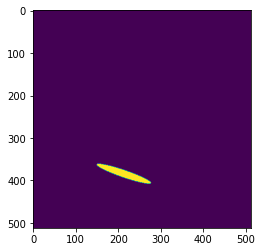

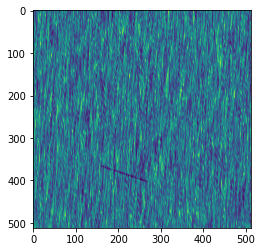

In [ ]:
i=cv2.imread(mask_path[0])
i2=cv2.imread(img_path[0])
print(i.shape)
plt.imshow(i[:,:,0])
plt.show()
plt.imshow(i2[:,:,0])

Creating a black image as the segmenation map for the non defective images

In [ ]:
non_mask_files=os.listdir("woboto/train/train")[6:]
print(non_mask_files)

['Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class1']


In [ ]:
def compute_masks_2(file_name):
    df_1=pd.DataFrame()
    
    l=os.listdir(file_name)
    path=[]
    original_path=[]
    for i in (l):
      if i.endswith(".png"):
        
        k=cv2.imread(file_name+"/"+i)
        w,h,g=k.shape
      # print(w,h,max(rr),max(cc))
        img = np.zeros((w,h), dtype=np.uint8)
        im = Image.fromarray(img) 

        im.save(file_name+"/masks/"+i)
       
        path.append(file_name+"/masks/"+i)
        
        original_path.append(file_name+"/"+i)

        
      
    return path,original_path 

In [ ]:

non_mask_img_path=[]
non_mask_path=[]
import tqdm
from tqdm import tqdm
for i in tqdm(non_mask_files):
  p,orig=compute_masks_2("woboto/train/train/"+i)
  non_mask_path.extend(p)
  non_mask_img_path.extend(orig)


100%|██████████| 5/5 [00:00<00:00, 93.99it/s]

['Class2', 'Class3', 'Class4', 'Class5', 'Class6']


A non defective image segmentation map and corresponding image

(512, 512, 3)


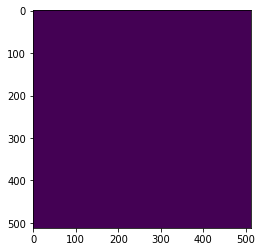

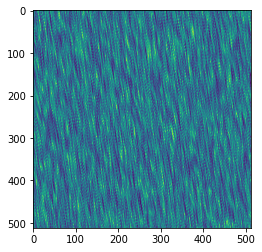

In [ ]:
i=cv2.imread(non_mask_path[0])
i2=cv2.imread(non_mask_img_path[0])
print(i.shape)
plt.imshow(i[:,:,0])
plt.show()
plt.imshow(i2[:,:,0])


Build the train data set using the defective images and a sample of non defective images. So we took a sample of paths from the set of all non defectve images and form the image array and mask array

In [ ]:

images=np.random.choice(img_path,100)
masks=np.random.choice(mask_path,100)


In [ ]:
#img path contains the paths of all defective images and a sample of non defective images
img_path.extend(images)
#mask path conatins the path to the segmenation maps of the image in img_path list
mask_path.extend(masks)


In [11]:
df_new=pd.DataFrame()
df_new["image"]=img_path
df_new["mask"]=mask_path
df_new.to_csv("df_masked")

In [ ]:
df_new=pd.read_csv("df_masked")

In [12]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df_new,test_size=0.25)

## Training of UNET model


In [13]:
!pip install imgaug
!pip install -U segmentation-models

In [14]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import imgaug.augmenters as iaa
import segmentation_models as sm
from segmentation_models import Unet 

Segmentation Models: using `keras` framework.


In [17]:
#loading the unet model
model=Unet("resnet34",encoder_weights="imagenet",classes=1,activation="sigmoid",input_shape=(512,512,3),encoder_freeze=True)

85524480/85521592 [==============================] - 1s 0us/step


In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [19]:

class Dataset:
  
    CLASSES = [1]
    
    def __init__(self, df,w,h,classes):
        
        self.df = df
        # the paths of images
        self.images_fps   = [df["image"][image_id] for image_id in self.df.index]
        # the paths of segmentation images
        self.masks_fps    = [df["mask"][image_id] for image_id in self.df.index]
        
        self.w=w
        self.h=h
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        mask  = cv2.imread(self.masks_fps[i],cv2.IMREAD_UNCHANGED)
        image_mask  = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        
                                  
        image_mask= [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_mask, axis=-1).astype('float')
         
            
        return image, image_mask

    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset,shape, batch_size,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shape=shape
        self.indexes = np.arange(self.shape)

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size 
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [20]:
w=512
h=512
CLASSES = [1]
train_dataset = Dataset(df_train,w,h,classes=CLASSES)
test_dataset  = Dataset(df_test,w,h,classes=CLASSES)


In [21]:

train_dataloader = Dataloder(train_dataset,df_train.shape[0],batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset,df_test.shape[0], batch_size=4, shuffle=True)


In [22]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(4, 512, 512, 3)
(4, 512, 512, 1)


Displaying an image and the corresponding segmenation map

(512, 512, 1)


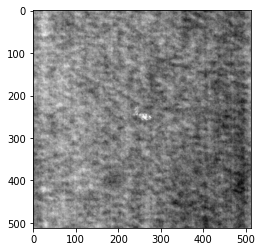

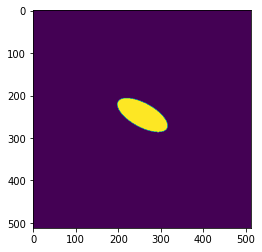

In [23]:
images_fps   = [df_train["image"][image_id] for image_id in df_train.index]
for i in range(len(images_fps)):
  if "def" in images_fps[i]:
    x=i
    
masks_fps    = [df_train["mask"][image_id] for image_id in df_train.index]
image1 = cv2.imread(images_fps[x])
mask1  = cv2.imread(masks_fps[x], cv2.IMREAD_UNCHANGED)
mask1  = cv2.resize(mask1,(w,h),interpolation=cv2.INTER_AREA)
mask1=np.expand_dims(mask1,axis=-1)
print(mask1.shape)
plt.imshow(image1)
plt.show()
plt.imshow(mask1[:,:,0])

In [24]:
from segmentation_models.metrics import iou_score

opt=tf.keras.optimizers.Adam(0.001)

loss1 = sm.losses.categorical_focal_dice_loss
model.compile(optimizer=opt,loss=loss1,metrics=[iou_score])

Training the Unet model

In [ ]:
print(tf.test.gpu_device_name())
model.fit_generator(train_dataloader,validation_data=test_dataloader,epochs=10)

model.save_weights("woboto/unet_epoch10_a.h5")
print("saved")  

/device:GPU:0
Epoch 1/10
165/165 [==============================] - 75s 454ms/step - loss: 0.0446 - iou_score: 0.9210 - val_loss: 0.0150 - val_iou_score: 0.9602
Epoch 2/10
165/165 [==============================] - 67s 408ms/step - loss: 0.0142 - iou_score: 0.9725 - val_loss: 0.0275 - val_iou_score: 0.9368
Epoch 3/10
165/165 [==============================] - 67s 406ms/step - loss: 0.0123 - iou_score: 0.9764 - val_loss: 0.0112 - val_iou_score: 0.9759
Epoch 4/10
165/165 [==============================] - 67s 407ms/step - loss: 0.0116 - iou_score: 0.9779 - val_loss: 0.0057 - val_iou_score: 0.9772
Epoch 5/10
165/165 [==============================] - 67s 408ms/step - loss: 0.0111 - iou_score: 0.9788 - val_loss: 0.0063 - val_iou_score: 0.9776
Epoch 6/10
165/165 [==============================] - 67s 408ms/step - loss: 0.0104 - iou_score: 0.9803 - val_loss: 0.0251 - val_iou_score: 0.9771
Epoch 7/10
165/165 [==============================] - 67s 408ms/step - loss: 0.0100 - iou_score: 0.9812 

In [25]:
model.load_weights("woboto/unet_epoch10_a.h5")

### Plotting the segmentation map on some validation set images

In [27]:
import random

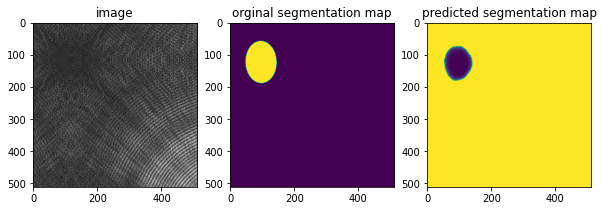

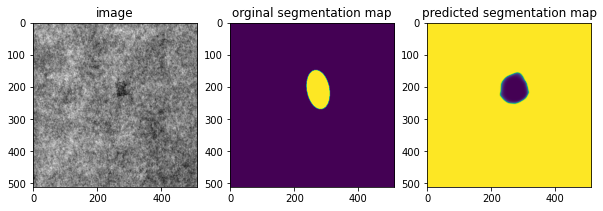

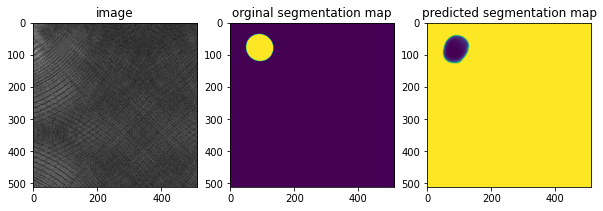

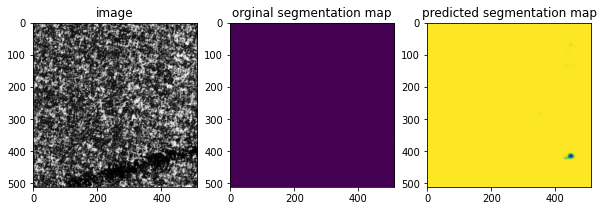

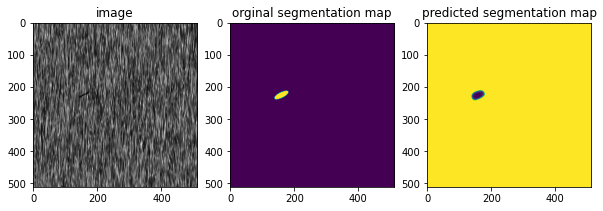

In [74]:
ids=list(df_train.index)

index=random.sample(ids,5)
for id in index:
  image = cv2.imread(df_train["image"][id])
  image = cv2.resize(image, (512,512)) 
    #predicted segmentation map
  predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
  image_mask = cv2.imread(df_train["mask"][id], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (512,512))
    

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image")
  plt.imshow(image)
  plt.subplot(132)
  plt.title("orginal segmentation map")
  plt.imshow(image_mask)
  
  plt.subplot(133)
  z=np.ones(shape=(512,512,3),dtype="float32")
  plt.title("predicted segmentation map")
  
  z=(predicted[0][:,:,0])
  plt.imshow(z)
  plt.show()

### Finding the segmentation map on the test set images

Creating the test dataframe

In [29]:
test_files=os.listdir("woboto/test/test/")
labels=[]
path=[]
for cls in test_files:
  path.append("woboto/test/test/"+cls)
        
test=pd.DataFrame()
test["image"]=path

In [30]:
model.load_weights("woboto/unet_epoch10_a.h5")

### Printing the segmentation maps and saving the images in the folder test_outputs in .jpeg format

In [68]:
os.mkdir("woboto/test_outputs")

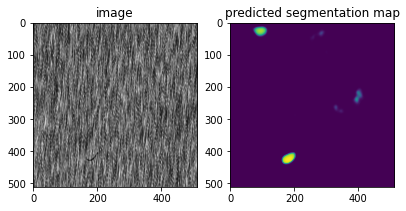

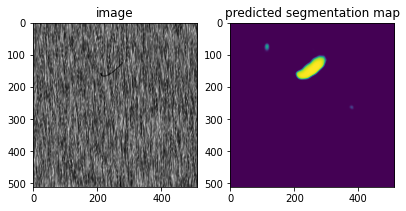

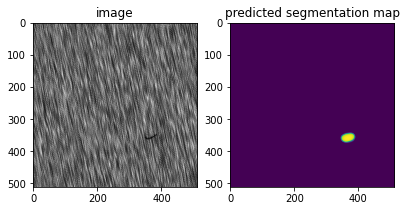

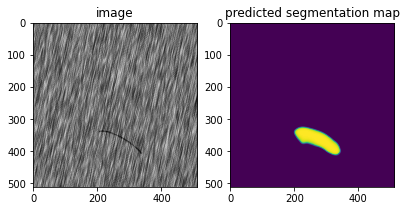

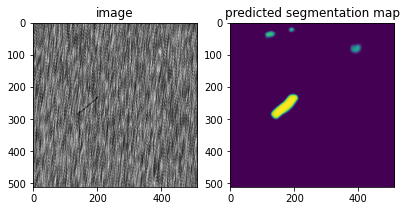

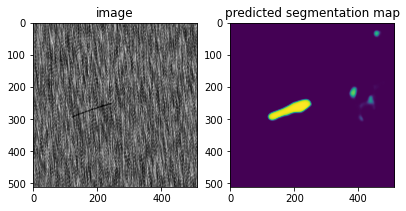

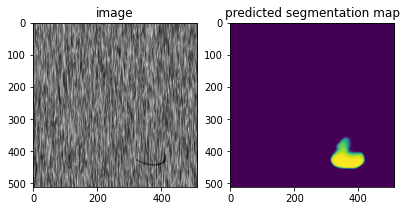

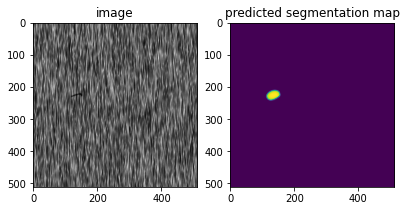

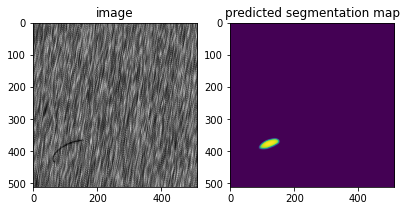

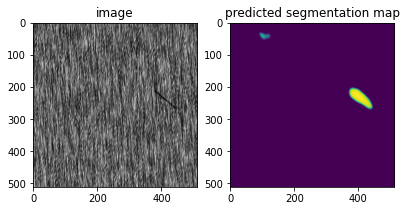

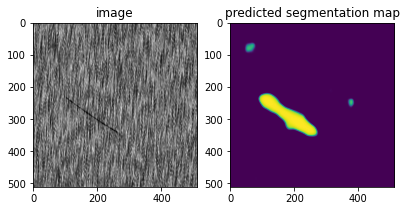

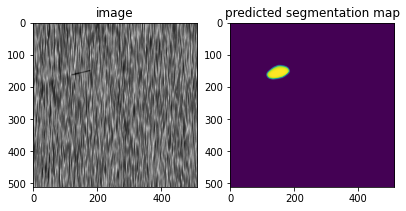

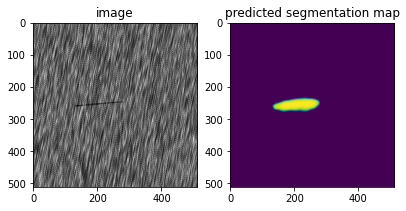

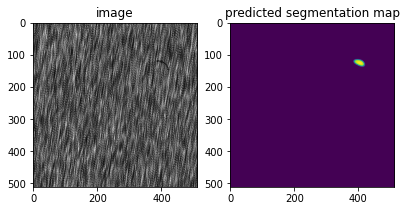

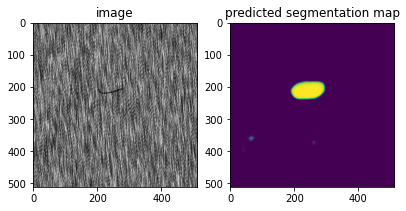

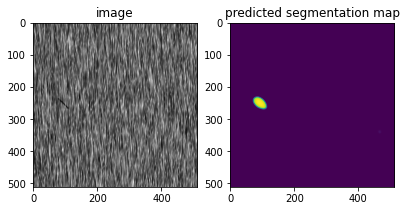

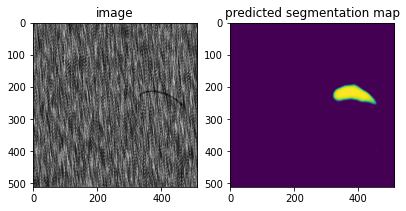

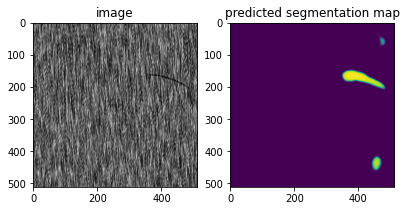

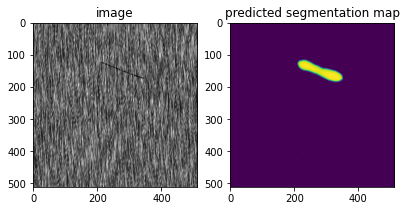

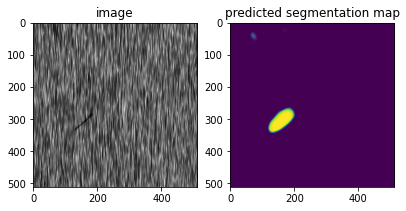

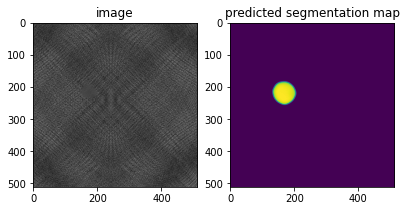

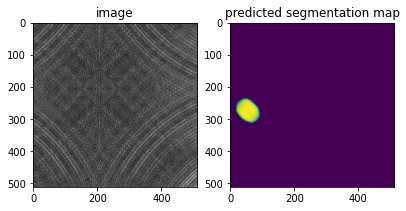

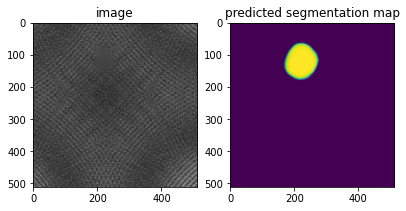

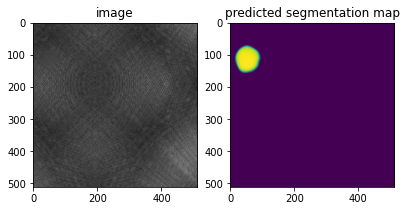

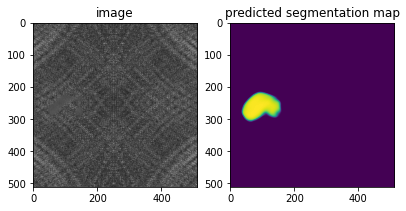

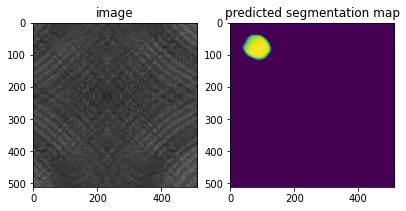

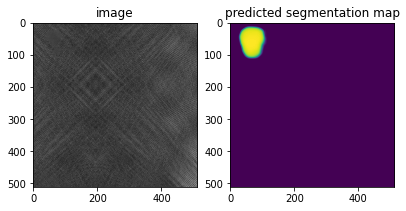

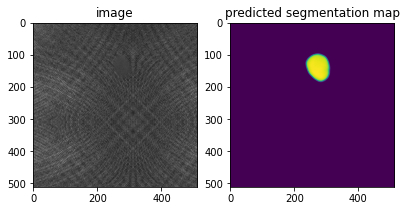

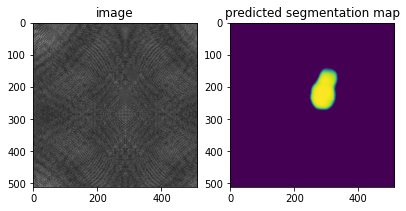

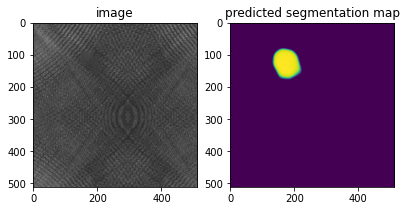

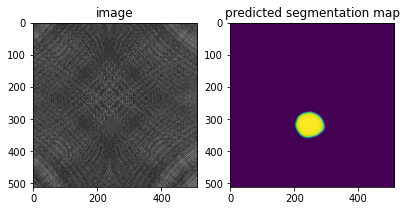

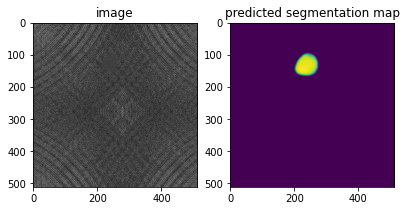

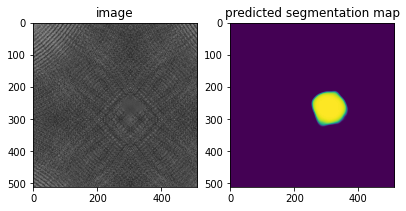

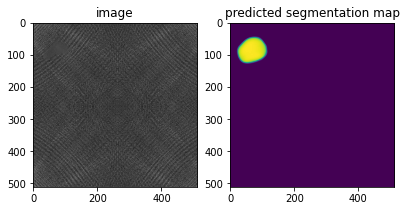

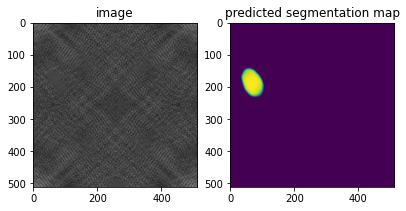

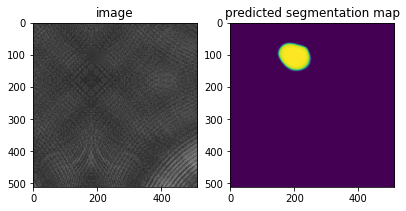

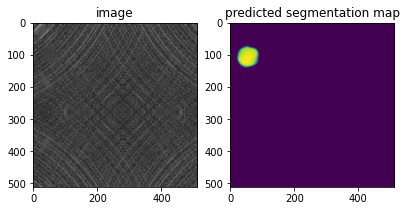

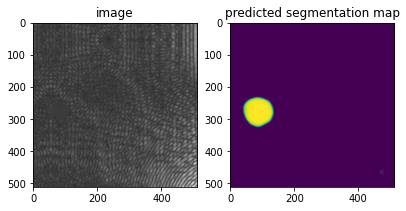

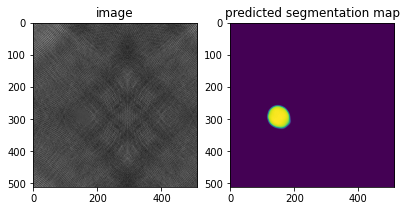

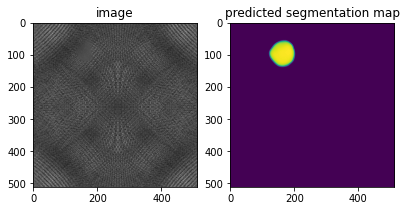

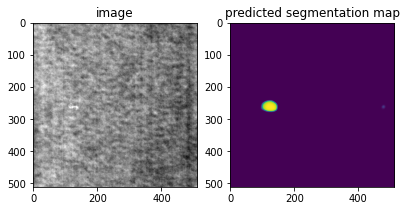

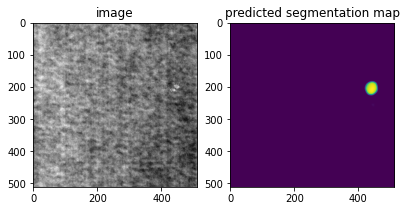

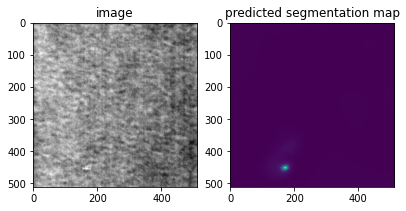

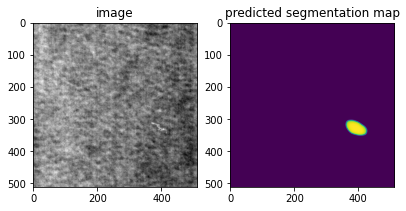

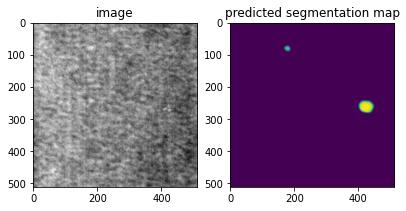

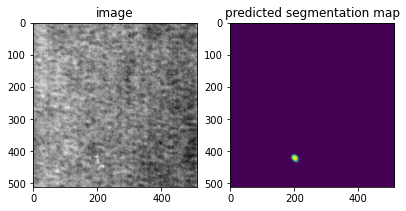

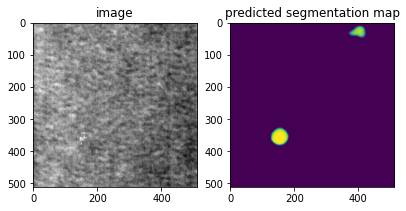

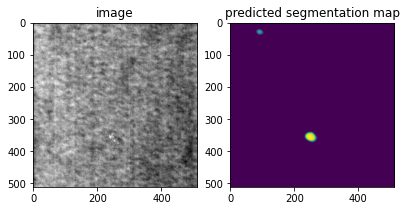

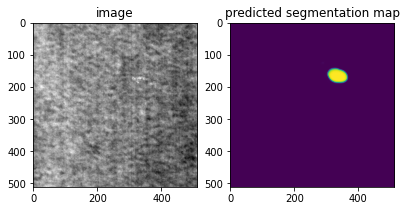

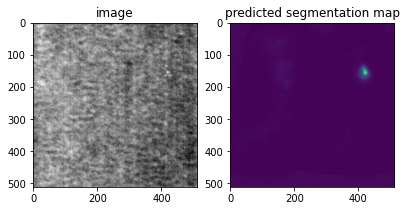

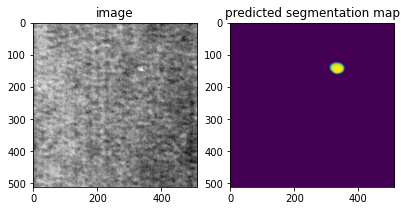

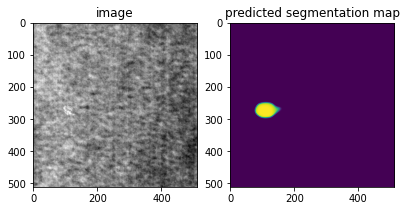

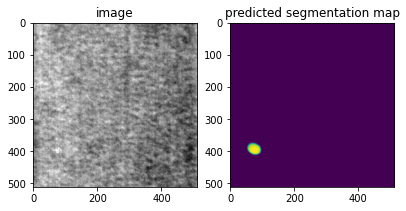

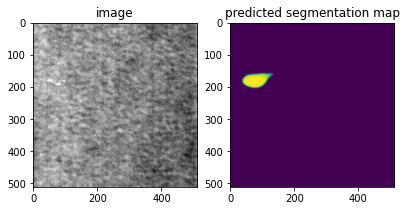

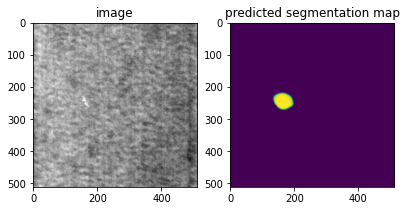

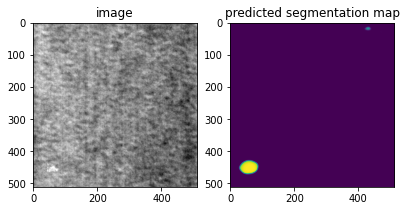

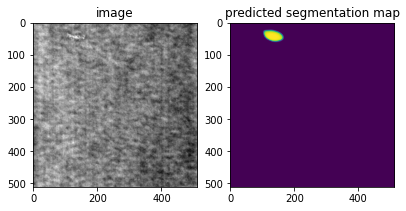

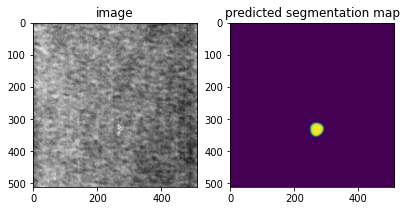

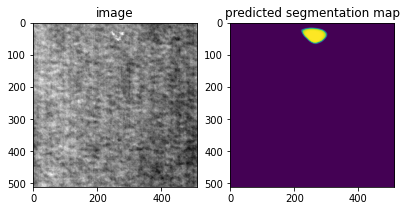

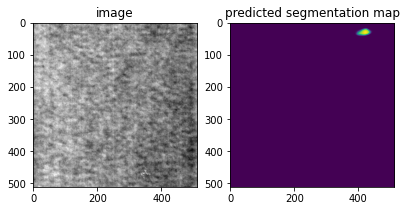

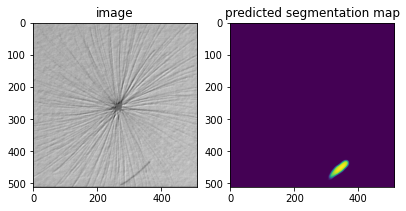

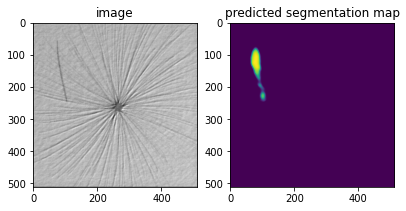

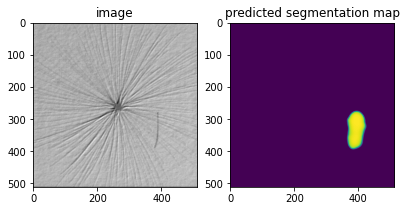

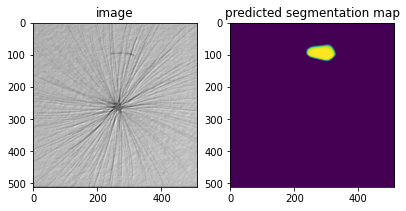

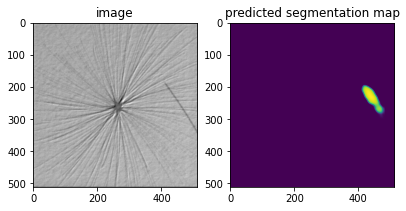

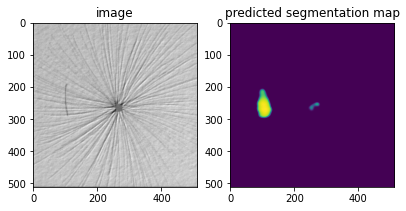

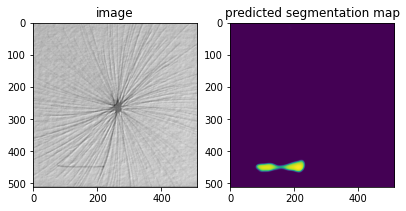

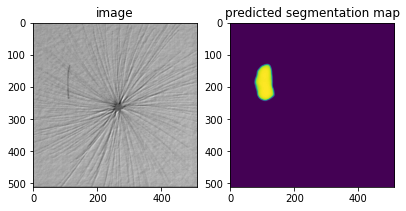

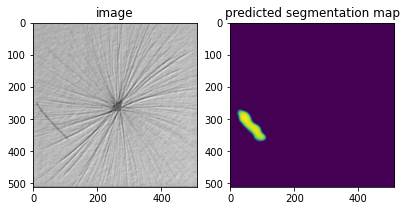

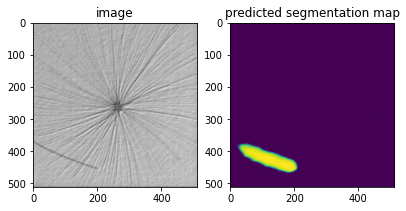

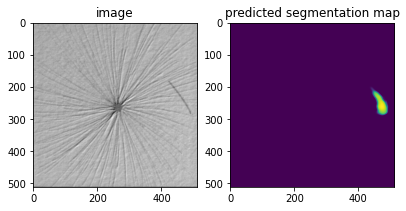

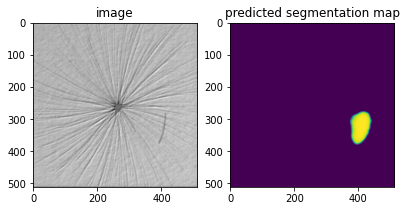

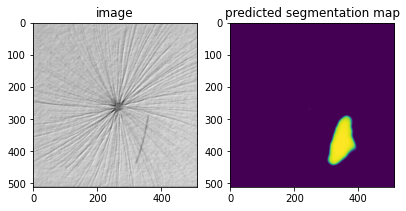

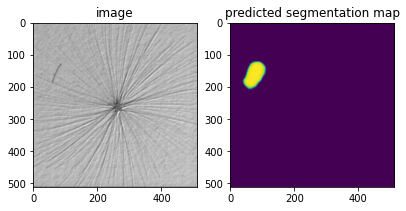

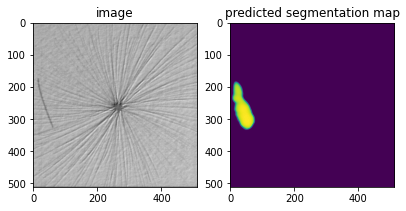

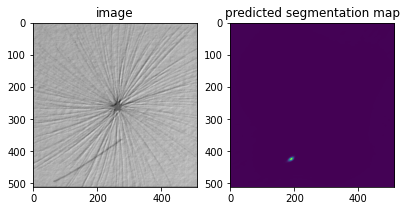

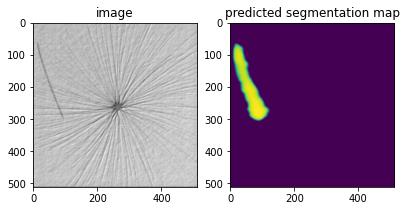

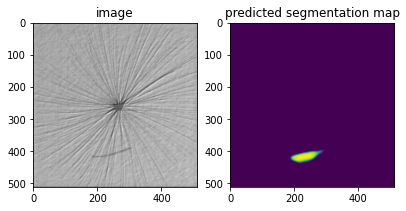

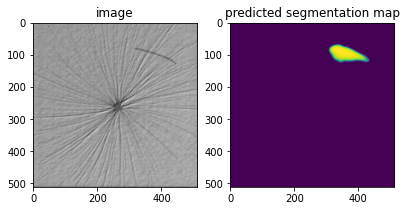

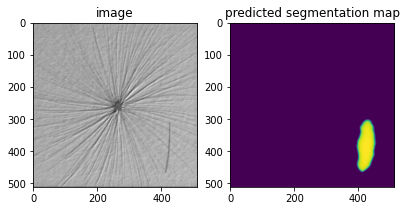

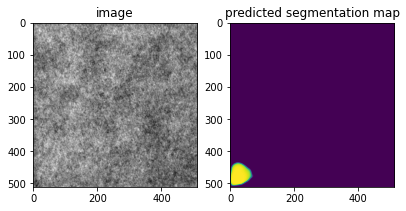

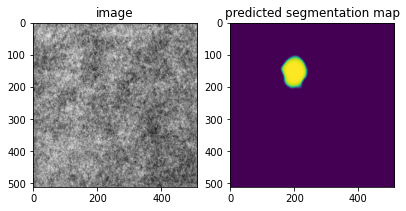

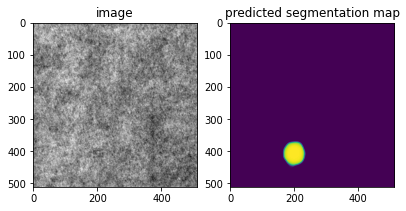

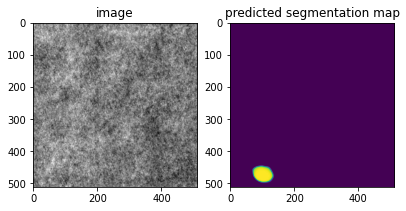

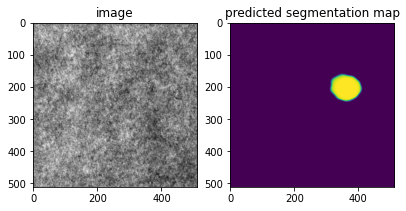

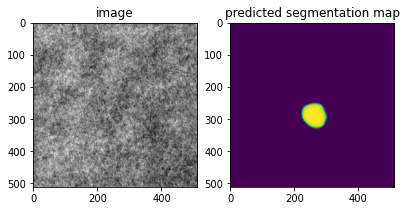

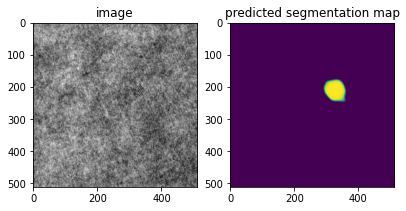

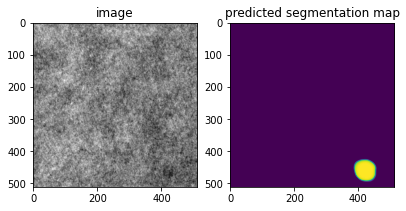

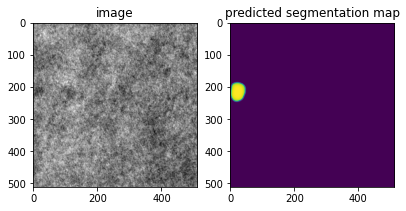

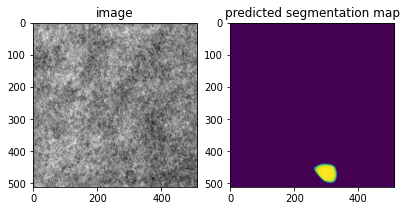

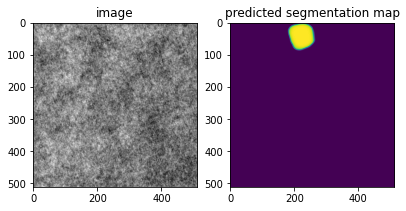

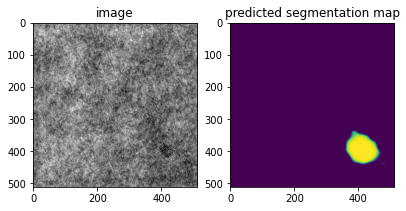

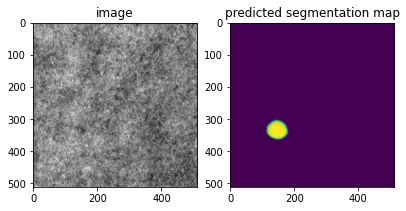

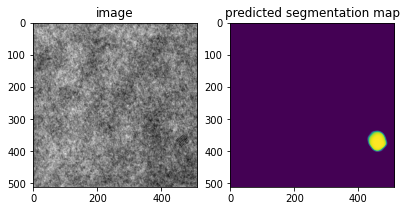

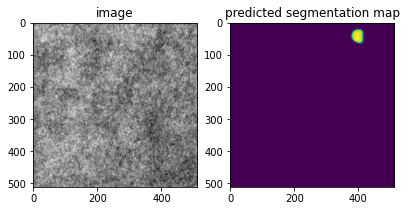

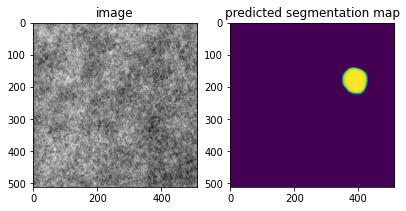

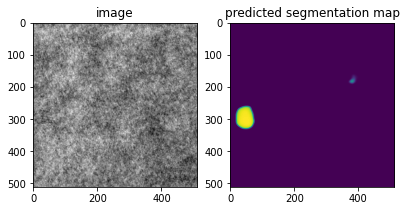

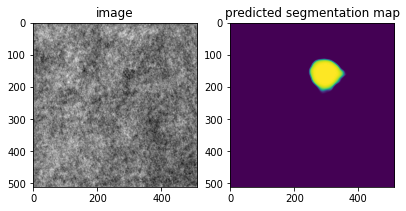

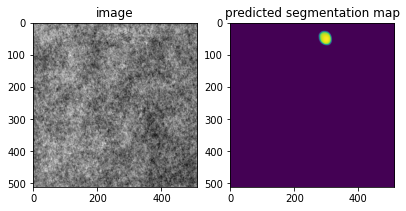

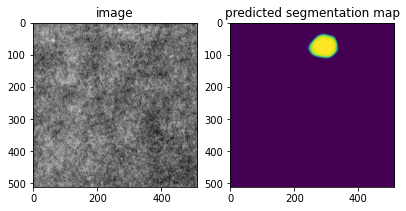

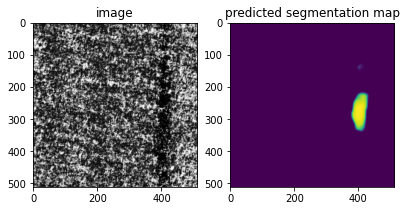

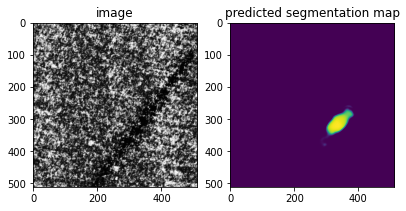

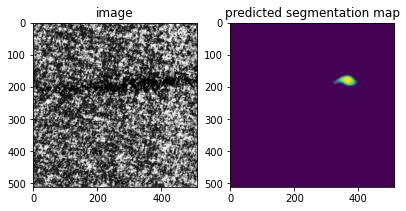

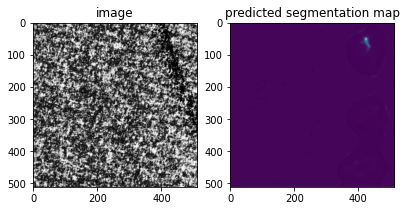

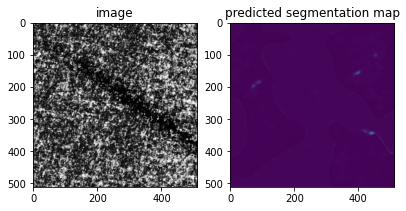

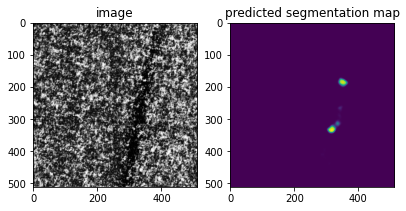

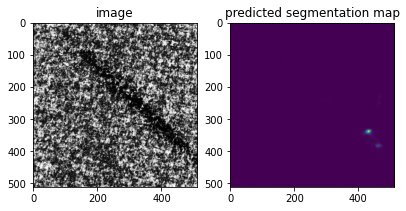

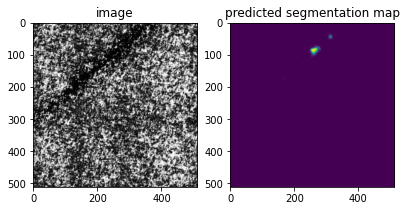

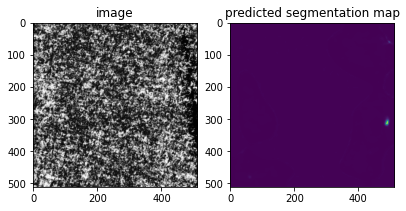

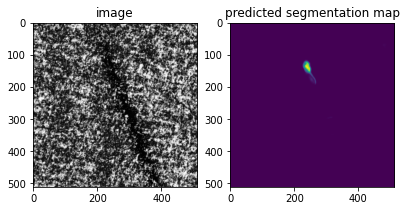

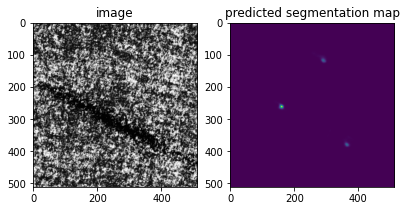

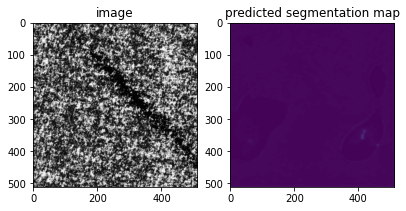

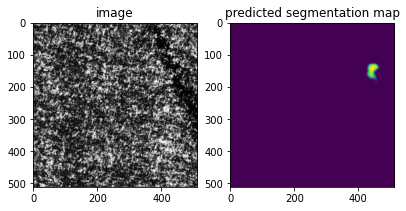

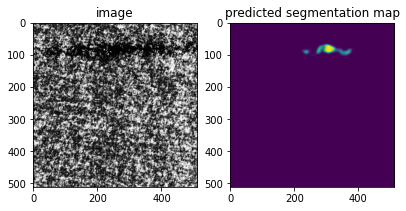

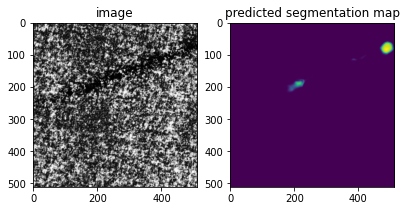

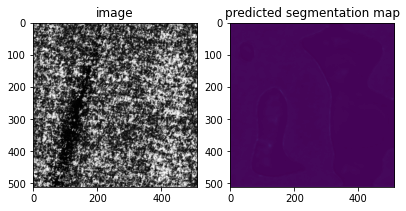

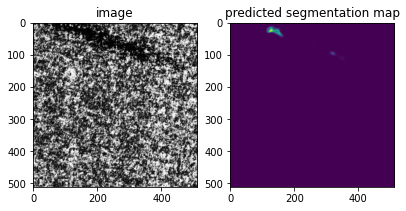

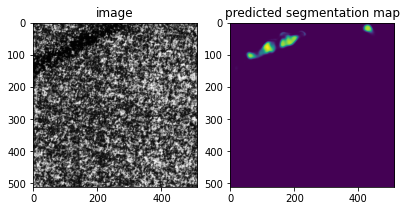

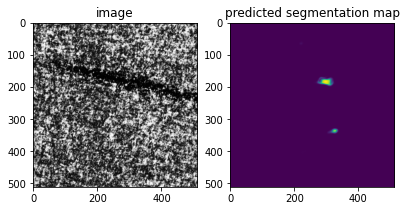

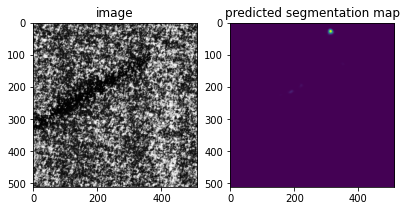

In [70]:
import random
import PIL
import PIL.ImageOps    
index=list(test.index)
model.load_weights("woboto/unet_epoch10_a.h5")
for id in index:
  image = cv2.imread(test["image"][id])
  image = cv2.resize(image, (512,512)) 
    #predicted segmentation map
  predicted  = model.predict(image[np.newaxis,:,:,:])
    
    

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.title("image")
  plt.imshow(image)
  
  plt.subplot(132)
  z=np.ones(shape=(512,512,3),dtype="float32")
  plt.title("predicted segmentation map")
  
  z=(predicted[0][:,:,0])
  z = (255-z)
  plt.imsave("woboto/test_outputs/"+test["image"][id].split("/")[3].split(".")[0]+".jpeg", z, cmap='gray')
  
  plt.imshow(z)
  plt.show()
  

In [71]:
len(os.listdir("woboto/test_outputs"))

120

### Conclusion

1. Created segmenation mask for all the images using the information provided

2. Took the defective images and a sample of non-defective images and their corresponding masked images for training the Unet model

3. The model gave a good performance and was able to detect the defect in all defective images

4. The model is tested on the test data and the corresponding binary segmenation map was saved in.jpeg format